In [1]:
# Usual Libraries USED FROM THE OTHER NOTEBOOK WE ADD MORE OR DELETE WHEN NECESSESARRY 
import pandas as pd
import numpy as np
import distutils

import os
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

In [2]:

def parse_tfrecord(example_proto):
    # Define the feature description dictionary
    feature_description = {
        'audio_embedding': tf.io.FixedLenFeature([128], tf.float32),  # Assuming embeddings are of length 128
        'label': tf.io.FixedLenFeature([], tf.int64)  # Adjust if labels are present or use appropriate types
    }
    
    # Parse the input tf.train.Example proto using the dictionary above
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    
    # Extract the audio embedding and label
    audio_embedding = parsed_features['audio_embedding']
    label = parsed_features['label']
    
    # You may need to reshape or modify this for CNN compatibility
    audio_embedding = tf.reshape(audio_embedding, (128, 1))  # Example of reshaping
    
    return audio_embedding, label

Audio Embedding Shape: (10, 128)
Labels: tf.Tensor([  0 393], shape=(2,), dtype=int64)


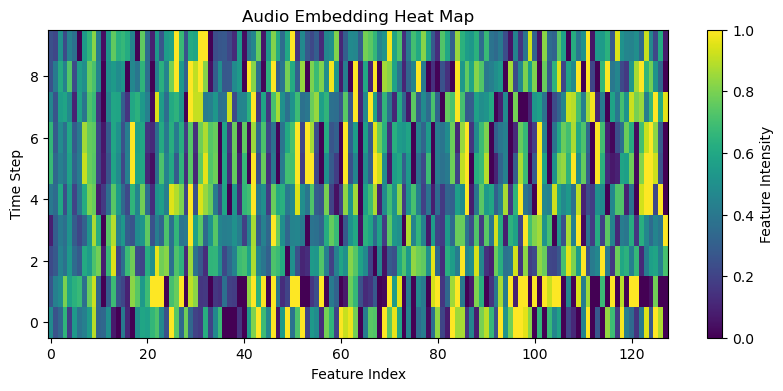

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Define the context features
context_features = {
    'video_id': tf.io.FixedLenFeature([], tf.string),
    'start_time_seconds': tf.io.FixedLenFeature([], tf.float32),
    'end_time_seconds': tf.io.FixedLenFeature([], tf.float32),
    'labels': tf.io.VarLenFeature(tf.int64)
}

# Define the sequence features
sequence_features = {
    'audio_embedding': tf.io.VarLenFeature(tf.string)
}

def _parse_function(example_proto):
    # Parse the example into context and sequence features
    context_data, sequence_data = tf.io.parse_single_sequence_example(
        example_proto,
        context_features=context_features,
        sequence_features=sequence_features
    )
    
    # Decode the audio embeddings from the byte strings
    audio_embeddings = tf.io.decode_raw(sequence_data['audio_embedding'].values, tf.uint8)
    audio_embeddings = tf.reshape(audio_embeddings, [-1, 128])  # Reshape to [time, embedding size]
    
    # Normalize the embeddings to the range [0, 1]
    audio_embeddings = tf.cast(audio_embeddings, tf.float32) / 255.0

    labels = tf.sparse.to_dense(context_data['labels'])  # Convert sparse labels to dense

    return audio_embeddings, labels

# Apply the parsing function to your TFRecord dataset
raw_dataset = tf.data.TFRecordDataset('C:\\Users\\brigg\\OneDrive\Desktop\\New folder\\Music-Capstone-2\\.github\\Data\\bal_train\\__.tfrecord')
parsed_dataset = raw_dataset.map(_parse_function)

# Iterate over the parsed dataset to visualize a heat map
for audio_embedding, labels in parsed_dataset.take(1):
    print("Audio Embedding Shape:", audio_embedding.shape)
    print("Labels:", labels)

    # Convert the audio embedding to a NumPy array for visualization
    audio_embedding_np = audio_embedding.numpy()

    # Plot the heat map
    plt.figure(figsize=(10, 4))
    plt.imshow(audio_embedding_np, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='Feature Intensity')
    plt.xlabel('Feature Index')
    plt.ylabel('Time Step')
    plt.title('Audio Embedding Heat Map')
    plt.show()


In [17]:
def load_tfrecord_dataset(tfrecord_dir, batch_size=32):
    # Create a list of all TFRecord files in the directory
    tfrecord_files = [os.path.join(tfrecord_dir, file) for file in os.listdir(tfrecord_dir) if file.endswith('.tfrecord')]
    
    # Load the dataset from these TFRecord files
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    
    # Parse each example in the dataset
    dataset = dataset.map(parse_tfrecord)
    
    # Shuffle, batch, and prefetch the data for performance
    dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset



In [18]:

tfrecord_directory = 'Data/features.tar/audioset_v1_embeddings/bal_train'

# Load the dataset
dataset = load_tfrecord_dataset(tfrecord_directory)

# Check the data shapes
for audio_embedding, label in dataset.take(1):
    print("Audio Embedding Shape:", audio_embedding.shape)
    print("Label:", label)


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Feature: audio_embedding (data type: float) is required but could not be found.
	 [[{{node ParseSingleExample/ParseExample/ParseExampleV2}}]] [Op:IteratorGetNext] name: 

In [ ]:
# Assuming dataset is your parsed dataset from the TFRecord
batch_size = 32
num_epochs = 10

# Prepare dataset for training
def prepare_for_training(dataset, batch_size=32, shuffle_buffer_size=1000):
    dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

train_dataset = prepare_for_training(dataset, batch_size=batch_size)

# Train the model
model.fit(train_dataset, epochs=num_epochs)


In [ ]:
# Assuming you have a test dataset parsed similarly to train_dataset
test_dataset = prepare_for_training(test_dataset, batch_size=batch_size, shuffle_buffer_size=1)

# Evaluate model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy}")


In [ ]:
def preprocess_embeddings(audio_embeddings, max_time_steps):
    # Example: Padding or truncating the sequence of embeddings to a fixed length
    audio_embeddings = tf.keras.preprocessing.sequence.pad_sequences(
        audio_embeddings, maxlen=max_time_steps, padding='post', truncating='post')
    
    # Optionally normalize the embeddings (assuming they're in uint8 format)
    audio_embeddings = tf.cast(audio_embeddings, tf.float32) / 255.0  # normalize from 0 to 1
    
    return audio_embeddings


In [ ]:
# Save the model
model.save('audio_classification_model.h5')

# Load the model
loaded_model = tf.keras.models.load_model('audio_classification_model.h5')
